<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:

# begin by importing the necessary tools to view the dataframe
import pandas as pd

df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.zip')

In [2]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [3]:
# check the shape and the column names to figure out what we want to manipulate
df.shape

(28332, 24)

In [4]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [5]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [6]:
# importing the spacy library so that we can use the NLP model to tokenize our reviews

import spacy

nlp = spacy.load('en_core_web_lg')

In [7]:
stop_words = nlp.Defaults.stop_words

def get_lemmas(text):
    
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc:
        conditions = (token.is_stop == False) and (token.is_punct == False) and (token.pos_ !='PRON') and (token is not stop_words)
        if conditions:
            lemmas.append(token.lemma_)
            
    return lemmas

In [8]:
df['reviews.text'] = df['reviews.text'].apply(get_lemmas)

In [9]:
# importing gensim and its tools so that we can build a topic model to use on our data

import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [13]:
import pyLDAvis.gensim

In [11]:
id2word = corpora.Dictionary(df['reviews.text'])

In [ ]:
id2word.filter_extremes(no_below=50, no_above=.90)

In [12]:
len(id2word.keys())

9706

In [17]:
corpus = [id2word.doc2bow(doc) for doc in df['reviews.text']]

In [18]:
# Build the model, in similar fashion as when we build pipelines. the below parameters are what are always used in Topic Modelling

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics = 10,
                   passes = 100,
                   workers = 12,
                   random_state = 323
                   )

In [19]:
lda.print_topics()

[(0,
  '0.021*"good" + 0.019*"like" + 0.019*"screen" + 0.016*"tablet" + 0.016*"great" + 0.013*"sound" + 0.010*"speaker" + 0.009*"charge" + 0.009*"Alexa" + 0.008*"ad"'),
 (1,
  '0.122*"great" + 0.114*"price" + 0.113*"good" + 0.043*"work" + 0.038*"battery" + 0.027*"product" + 0.027*"tablet" + 0.026*"buy" + 0.023*"quality" + 0.023*"value"'),
 (2,
  '0.047*"tablet" + 0.029*"Amazon" + 0.026*"app" + 0.019*"use" + 0.016*"watch" + 0.015*"screen" + 0.014*"movie" + 0.014*"great" + 0.012*"iPad" + 0.011*"device"'),
 (3,
  '0.094*"love" + 0.048*"old" + 0.048*"buy" + 0.043*"year" + 0.035*"tablet" + 0.024*"daughter" + 0.024*"gift" + 0.024*"game" + 0.021*"play" + 0.020*"Christmas"'),
 (4,
  '0.068*"book" + 0.061*"read" + 0.031*"great" + 0.029*"recommend" + 0.026*"love" + 0.025*"game" + 0.019*"enjoy" + 0.016*"tablet" + 0.014*"product" + 0.014*"kindle"'),
 (5,
  '0.041*"reader" + 0.037*"need" + 0.028*"good" + 0.028*"thank" + 0.021*"e" + 0.019*"light" + 0.017*"fit" + 0.016*"look" + 0.015*"hand" + 0.015*"

In [20]:
import re

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [21]:
topics = [' '.join(t[0:5]) for t in words]

In [22]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
good like screen tablet great

------ Topic 1 ------
great price good work battery

------ Topic 2 ------
tablet Amazon app use watch

------ Topic 3 ------
love old buy year tablet

------ Topic 4 ------
book read great recommend love

------ Topic 5 ------
reader need good thank e

------ Topic 6 ------
Kindle Fire tablet fire kindle

------ Topic 7 ------
easy use love great read

------ Topic 8 ------
battery long brand work buy

------ Topic 9 ------
kid tablet app great child



In [23]:
pyLDAvis.enable_notebook()

In [24]:
# This graph shows us the intertopic distance of each topic. This means that we can discover exactly which tokens were most important in defining our topics.
# adjust the relevance metric to discover the importance for each category. The smaller the relevance matrix, the more specific it gets.

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.160289  0.178612       1        1  21.168196
1     -0.230888 -0.007946       2        1  12.126211
9      0.099036  0.083166       3        1  11.276593
3      0.219556  0.080881       4        1  11.133298
2      0.027097  0.003803       5        1  10.308661
0     -0.076769  0.054743       6        1   8.137575
6      0.019544  0.079964       7        1   8.022746
7      0.134615 -0.127248       8        1   7.703097
4      0.116670 -0.116631       9        1   5.856189
5     -0.148572 -0.229343      10        1   4.267424, topic_info=          Term         Freq        Total Category  logprob  loglift
4      battery  8632.000000  8632.000000  Default  30.0000  30.0000
19       price  4853.000000  4853.000000  Default  29.0000  29.0000
33        easy  3283.000000  3283.000000  Default  28.0000  28.0000
34        good  6682.000000  6682.000000  Default  27.0000  27.0000
88        love  5780.000000  5780.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3953    tablet   146.847061  7859.345703  Topic10  -4.5620  -0.8259
39    purchase   120.674026  2499.493408  Topic10  -4.7583   0.1234
22       great   102.941101  8921.908203  Topic10  -4.9172  -1.3079
31         buy    97.148140  5475.081543  Topic10  -4.9752  -0.8776
246       fast    94.860695   867.273315  Topic10  -4.9990   0.9412

[732 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5718      3  0.070575      $
5718      5  0.228193      $
5718      6  0.058813      $
5718      7  0.583420      $
5718      9  0.056460      $
...     ...       ...    ...
1109      4  0.328168  young
1109      9  0.012006  young
1456      3  0.166553     yr
1456      4  0.832765     yr
7927      8  0.928796      ©

[1511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 10, 4, 3, 1, 7, 8, 5, 6])

In [25]:
doc_topics = [lda[doc] for doc in corpus]

In [26]:
doc_topics[0]

[(0, 0.3075698), (8, 0.6308097)]

In [27]:
def update(doc):
    d_dist = {k:0 for k in range(0,10)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in doc_topics]

In [28]:
dft = pd.DataFrame.from_records(new_distro)
dft.columns = topics

In [29]:
dft.head()

,good like screen tablet great,great price good work battery,tablet Amazon app use watch,love old buy year tablet,book read great recommend love,reader need good thank e,Kindle Fire tablet fire kindle,easy use love great read,battery long brand work buy,kid tablet app great child
0,0.307570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630810,0.000000
1,0.016673,0.191420,0.016670,0.016669,0.016673,0.016670,0.016670,0.016670,0.675213,0.016671
2,0.025007,0.416691,0.025001,0.025008,0.025006,0.025004,0.025008,0.025006,0.383266,0.025003
3,0.016667,0.849984,0.016667,0.016667,0.016668,0.016667,0.016670,0.016667,0.016675,0.016667
4,0.016667,0.474094,0.016667,0.016667,0.016668,0.016667,0.016667,0.016667,0.392568,0.016667


In [30]:
df['primary_topic'] = dft.idxmax(axis=1)

In [31]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,primary_topic
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,"[order, 3, item, bad, quality, miss, backup, s...",... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",battery long brand work buy
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,"[bulk, expensive, way, product, like]",... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",battery long brand work buy
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,"[Duracell, price, happy]",... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",great price good work battery
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,"[work, brand, battery, well, price]",... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",great price good work battery
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,"[battery, long, last, price, great]",... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",great price good work battery


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

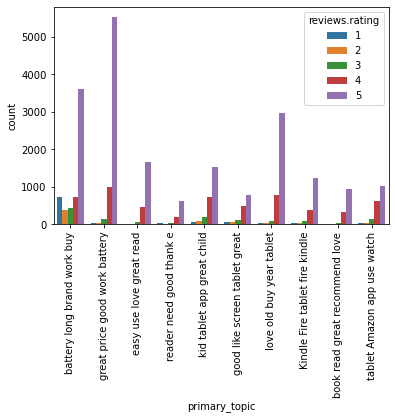

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="primary_topic", hue="reviews.rating", data=df)
plt.xticks(rotation=90)

Based on the above visual representation of topics, one of the most positively reviewed categories is batteries. They have far more 5 star reviews than any other number of star reviews. This can be contrasted with the review scores
for the 10th category, which has the key word tablet in it. That category has many less 5 star reviews, but nearly as many if not more 3 star reviews.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling